# RAPIDS and Cybersecurity : A Network Use Case

### ASONAM 2019 Tutorial
### Authors
 - Rachel Allen, PhD (NVIDIA) [rachela@nvidia.com]
 - Haekyu Park (Georgia Tech, NVIDIA)
 - Bartley Richardson, PhD (NVIDIA) [brichardson@nvidia.com]
 - Brad Rees, PhD [brees@nvidia.com]

### Table of Contents
* Introduction
* Data Importing and Formatting
* Data Exploration
    * Dataset Summary
    * Dataset Size and Data Types
    * Summary Statistics
    * Value Counts
    * Aggregate Statistics
    * Visualizing Data Distributions
* Graph Representation 
    * Degree
    * PageRank
    * Personalized PageRank
    * Graph Visualization
    
### Development Notes
 - Developed using: RAPIDS v0.9.0
 - Last tested using: RAPIDS v0.9.0 on August 20, 2019

In [1]:
# See how many GPUs are avaialble
!nvidia-smi

Fri Aug 23 07:36:28 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   46C    P0    57W / 300W |  24654MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   46C    P0    45W / 300W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
# since this is a shared machine - let's pick a GPU that no one else is using
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [3]:
import cudf
import pandas as pd
import dask_cudf
import cugraph

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Introduction

Today, organizations collect vast amounts of network traffic and network metadata. As the volume of data collected and velocity at which it's collected continue to increase, security analysts and forensic investigators require fast triage, processing, modeling, and visualization capabilities. Using the [RAPIDS](https://rapids.ai) suite of open-source software, we demonstrate how to:

1. Triage and perform data exploration,
2. Model network data as a graph,
3. Perform graph analytics on the graph representation of the cyber network data, and
4. Prepare the results in a way that is suitable for visualization.

# Data Import and Formatting

For this tutorial, we will used the [IDS 2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html) from the [Canadian Institute for Cybersecurity](https://www.unb.ca/cic/). The data is stored as raw PCAP files in AWS, and we'll need flow-level data for this use case. To make things eaiser, we've already created bidirectional flow using the [CIC FlowMeter tool](https://github.com/ISCX/CICFlowMeter). You can download it and get started immediately using the cell below. If you wish to store the data in a different location other than the default, change the value of `BASE_DIRECTORY`.

In [4]:
BASE_DIRECTORY = "../data/"
DOWNLOAD_DIRECTORY = BASE_DIRECTORY + "cic_ids2018/"
DOWNLOAD_FILE = "Friday-02-03-2018-biflows.tar.gz"
DIR_AND_FILE = DOWNLOAD_DIRECTORY + DOWNLOAD_FILE
DATA_DIRECTORY = DOWNLOAD_DIRECTORY + DOWNLOAD_FILE.split('.')[0] + "/"

In [5]:
!mkdir -p $DOWNLOAD_DIRECTORY
!if [ ! -f $DIR_AND_FILE ]; then echo ">> Downloading data" && wget -O $DIR_AND_FILE https://rapidsai-data.s3.us-east-2.amazonaws.com/cyber/kdd2019/Friday-02-03-2018-biflows.tar.gz; else echo ">> Data already downloaded"; fi
!if [ ! -d $DATA_DIRECTORY ]; then echo ">> Extracting $DOWNLOAD_FILE to $DATA_DIRECTORY" && tar -xzf $DIR_AND_FILE -C $DOWNLOAD_DIRECTORY; else echo ">> Data already extracted to $DATA_DIRECTORY"; fi

>> Data already downloaded
>> Data already extracted to ../data/cic_ids2018/Friday-02-03-2018-biflows/


If you would prefer to create your own biflow data, [follow the directions at the bottom of this page to download the data](https://www.unb.ca/cic/datasets/ids-2018.html) to your machine. You'll then need to build and use the CIC FlowMeter tool to create biflow data.

----

### Load in `conn` (connection) logs into a GDF (GPU Data Frame)
Since there are 442 file, we could load each one in sequencially and then merge the DataFrame, but a better way is to use Dask-cuDF. Then we compute the GDF to convert to a cuDF data frame. 

Dask-cuDF is appropriate if your data doesn't fit in memory on a single GPU, you want to distribute your workflow across multiple GPUs, or (as is the case here) [you want to analyze data spread across many files at once](https://rapidsai.github.io/projects/cudf/en/latest/10min.html#When-to-use-cuDF-and-Dask-cuDF).

In [6]:
# specify the location of the data
DATA_LOCATION = DATA_DIRECTORY + "*.csv"

In [7]:
%%time
dask_gdf = dask_cudf.read_csv(DATA_LOCATION, 
                              sep=',',
                              dtype=["str","str","int32","str","int32","int32","str","int32","int32","int32",
                                     "float32","float32","float32","float32","float32","float32","float32",
                                     "float32","float32","float32","str","str","float32","float32","float32",
                                     "float32","float32","float32","float32","float32","float32","float32",
                                     "float32","float32","float32","float32","int32","int32","int32","int32",
                                     "int32","int32","float32","float32","float32","float32","float32","float32",
                                     "float32","int32","int32","int32","int32","int32","int32","int32","int32",
                                     "float32","float32","float32","float32","int32","int32","int32","int32",
                                     "int32","int32","int32","int32","int32","int32","int32","int32","int32",
                                     "int32","float32","float32","float32","float32","float32","float32","float32",
                                     "float32","str"])

CPU times: user 604 ms, sys: 588 ms, total: 1.19 s
Wall time: 1.21 s


In [8]:
%%time
gdf = dask_gdf.compute()

CPU times: user 26.1 s, sys: 3.09 s, total: 29.2 s
Wall time: 29.2 s


__That's it.__  data is loaded and ready for processing

----

We'll inspect the head of the new cuDF as a sanity check.

In [9]:
gdf.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:50:13 PM,112640178,2,1,...,0,0.0,0.0,0.0,0.0,56320092.0,159.806137,56320200.0,56319976.0,No Label
1,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:53:02 PM,112642593,2,1,...,0,0.0,0.0,0.0,0.0,56321296.0,120.915260,56321384.0,56321212.0,No Label
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:55:51 PM,112640127,2,1,...,0,0.0,0.0,0.0,0.0,56320068.0,251.022903,56320240.0,56319884.0,No Label
3,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:58:40 PM,112641715,2,1,...,0,0.0,0.0,0.0,0.0,56320852.0,67.175140,56320904.0,56320812.0,No Label
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 01:01:29 PM,112642245,2,1,...,0,0.0,0.0,0.0,0.0,56321120.0,3.535534,56321124.0,56321120.0,No Label


The timestamp is in string format, so we'll convert to epoch time.

In [10]:
%%time
gdf['datetime'] = gdf['Timestamp'].str.timestamp2int(format='%d/%m/%Y %I:%M:%S %p')

CPU times: user 728 ms, sys: 236 ms, total: 964 ms
Wall time: 978 ms


IP addresses in the dataset are also formatted as strings, in a format like: ```192.168.0.1``` We use one of the built-in IPv4 primitive functions `ip2int()` to convert IPv4 addresses to their integer (int64) representations.

In [11]:
%%time
gdf['src_ip'] = gdf['Src IP'].str.ip2int()
gdf['dst_ip'] = gdf['Dst IP'].str.ip2int()

CPU times: user 1.07 s, sys: 480 ms, total: 1.55 s
Wall time: 1.54 s


----

# Data Exploration

## Dataset Summary

There's 89 features for each flow! You can find descriptions of all of them here: https://www.unb.ca/cic/datasets/ids-2018.html. Or look at the table below with some of the ones we'll be using highlighted below.


|Field | Description|
|---|---|
|Src IP | Source IP
|Src Port | Source Port
|Dst IP| Destination IP
|Dst Port| Destination Port
|Tot Fwd Pkts| Total Forward Packets
|Tot Bwd Pkts| Total Backward Packets
|Fwd Header Len| Forward Header Length
|Bwd Header Len| Backward Header Lenght
|Fwd Pkts/s| Foward Packets per second
|Bwd Pkts/s | Backward Packets per second

## Data Exploration

### Dataset Size and Data Types

We first get a sense of how large the dataset is, and what some column names and their associated data types are.

In [12]:
print(gdf.shape)

(8217202, 87)


In [13]:
print(gdf.dtypes)

Flow ID               object
Src IP                object
Src Port               int32
Dst IP                object
Dst Port               int32
Protocol               int32
Timestamp             object
Flow Duration          int32
Tot Fwd Pkts           int32
Tot Bwd Pkts           int32
TotLen Fwd Pkts      float32
TotLen Bwd Pkts      float32
Fwd Pkt Len Max      float32
Fwd Pkt Len Min      float32
Fwd Pkt Len Mean     float32
Fwd Pkt Len Std      float32
Bwd Pkt Len Max      float32
Bwd Pkt Len Min      float32
Bwd Pkt Len Mean     float32
Bwd Pkt Len Std      float32
Flow Byts/s           object
Flow Pkts/s           object
Flow IAT Mean        float32
Flow IAT Std         float32
Flow IAT Max         float32
Flow IAT Min         float32
Fwd IAT Tot          float32
Fwd IAT Mean         float32
Fwd IAT Std          float32
Fwd IAT Max          float32
                      ...   
Down/Up Ratio        float32
Pkt Size Avg         float32
Fwd Seg Size Avg     float32
Bwd Seg Size A

### Summary Statistics on Numeric Fields

Often it's useful to generate summary statistics on numeric fields. This is easy with the `describe()` function. Here, the output includes the minimum, maximum, mean, median, standard deviation, and various quantiles for selected fields in the dataset.

In [14]:
print(gdf[['Flow Duration','Tot Fwd Pkts','Tot Bwd Pkts', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 
           'Bwd Pkts/s']].describe())

       Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  Fwd Header Len  \
count   8.217202e+06  8.217202e+06  8.217202e+06    8.217202e+06   
mean    1.601290e+07  5.229578e+00  7.693485e+00    1.013261e+02   
std     3.450459e+07  5.748743e+01  1.530253e+02    1.768820e+03   
min     0.000000e+00  0.000000e+00  1.000000e+00    0.000000e+00   
25%     6.480000e+02  1.000000e+00  2.000000e+00    0.000000e+00   
50%     2.041365e+05  2.000000e+00  2.000000e+00    2.000000e+01   
75%     4.082616e+06  7.000000e+00  8.000000e+00    1.400000e+02   
max     1.200000e+08  4.315800e+04  1.220150e+05    2.275004e+06   

       Bwd Header Len    Fwd Pkts/s    Bwd Pkts/s  
count    8.217202e+06  8.217202e+06  8.217202e+06  
mean     1.597771e+02  1.196901e+04  1.589824e+04  
std      3.028208e+03  1.072087e+05  1.082609e+05  
min      0.000000e+00  0.000000e+00  0.000000e+00  
25%      2.000000e+01  0.000000e+00  1.973443e+00  
50%      4.000000e+01  2.093290e+00  1.242776e+01  
75%      1.840000e+02  

### Value Counts of Fields

Ports are interesting. They help us determine what applications are being used by referring back to [IANA service mappings](https://www.iana.org/assignments/service-names-port-numbers/service-names-port-numbers.xhtml). For example, port 53 (UDP protocol) is commonly associated with DNS, while ports 80, 443, and 8080 (TCP protocol) are associated with HTTP and HTTPS. For TCP and UDP, ports are interpreted as you would imagine. However, network data often includes [ICMP](https://en.wikipedia.org/wiki/Internet_Control_Message_Protocol) traffic, which has no traditional notion of ports. In these cases, values for ports are interpreted as the [ICMP type](https://en.wikipedia.org/wiki/Internet_Control_Message_Protocol#Control_messages).

Let's investigate some of the destination ports and their value counts in the dataset.

In [15]:
# returns values from largest to smallest count
print(gdf['Dst Port'].value_counts())

53       2093020
3389     1909699
443      1040455
80        759641
445       462400
8080      281728
0         142358
5355       16314
3128       15323
123         9034
139         8095
67          7338
22          4310
137         4104
23          2854
138         1817
1900        1245
135         1216
500         1140
18183        727
7112         619
36496        532
30303        268
49705        256
49707        256
50467        252
50214        247
50392        247
50611        246
50085        245
          ...   
999            1
1013           1
1023           1
1029           1
5756           1
7390           1
12142          1
13786          1
14097          1
17815          1
21269          1
22795          1
24779          1
25748          1
28734          1
30109          1
30917          1
30970          1
31292          1
36502          1
36782          1
37211          1
37325          1
37572          1
38018          1
44327          1
45703          1
46057         

If we sort by the port, we can see that port 0 is represented quite frquently. This typically corresponds with ICMP traffic, meaning an echo reply (used to ping assets on the network).

In [16]:
# sort by port number
print(gdf['Dst Port'].value_counts().sort_index())

0         142358
3              1
5              2
10             3
12             1
15             2
21           223
22          4310
23          2854
25            56
26             1
53       2093020
67          7338
68            48
70             1
79             2
80        759641
81            36
82             2
83             2
84             1
85             3
88             3
89             1
90             3
91             2
101            1
102            2
110           13
111            8
          ...   
65506         10
65507         14
65508         11
65509         16
65510         11
65511         13
65512         11
65513          6
65514         16
65515         11
65516         15
65517         11
65518         12
65519         20
65520         13
65521         13
65522          9
65523          6
65524          7
65525         13
65526         14
65527         16
65528         14
65529          8
65530         10
65531          8
65532         14
65533         

### Aggregate Statistics

Another common way to investigate a new dataset is to calculate aggregate statistics on various fields (and groupings of fields) in the data. Below, we apply a `groupby()` then a `sum()` to calculate total forward-direction (outbound) packets for each source IP address.

In [17]:
print(gdf[['Src IP','Tot Fwd Pkts']].groupby('Src IP').sum())

                Tot Fwd Pkts
Src IP                      
0.0.0.0                  702
1.0.150.69                87
1.0.196.220               10
1.1.165.90               186
1.1.174.152               44
1.1.237.80                22
1.1.254.189               95
1.10.133.107              60
1.10.140.140              12
1.10.247.85               26
1.10.252.155              37
1.10.252.249              17
1.10.252.38              161
1.160.205.143             13
1.160.208.123             19
1.160.213.194             42
1.161.175.33              12
1.161.211.20             101
1.161.215.210            142
1.161.244.226            283
1.161.47.126              12
1.161.56.36               54
1.161.60.101             225
1.162.172.25              72
1.162.21.171              23
1.162.32.117             756
1.162.36.120               0
1.162.7.175                1
1.163.114.156             44
1.163.169.158             12
...                      ...
98.114.52.121            210
98.126.38.138 

## Visualizing Data Distribution

A big challenge for cyber security is to distinguish normal network traffic from malicious traffic. We can plot a feature's distribution to try to decide where a cut-offs for "normal" traffic could be.  

Let's start with something easy, ports (specifically destination ports, for the reasons above). 

In [18]:
plotdf = cudf.DataFrame()
plotdf['Dst Port'] = gdf['Dst Port'].value_counts().head(30).sort_index().index
plotdf['Freq'] = gdf['Dst Port'].value_counts().head(30).sort_index()

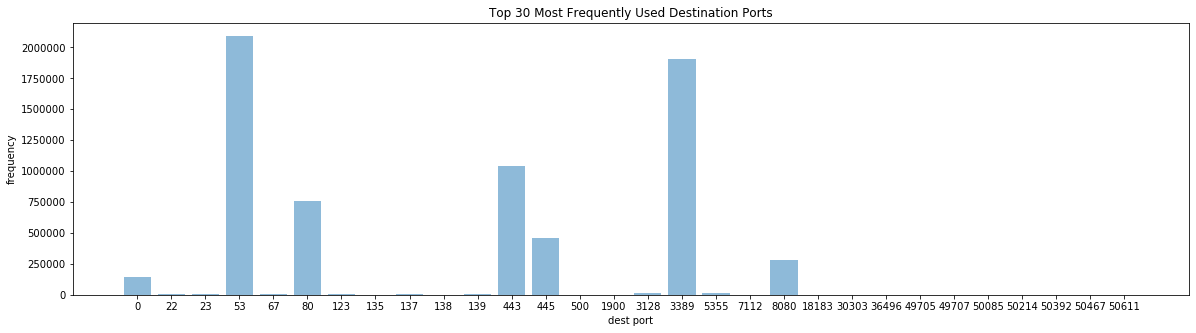

CPU times: user 276 ms, sys: 4 ms, total: 280 ms
Wall time: 275 ms


In [19]:
%%time
ports = plotdf['Dst Port']
y_pos = np.arange(len(ports))
frequency = plotdf['Freq']

plt.figure(figsize=(20,5))
plt.bar(y_pos, frequency, align='center', alpha=0.5)
plt.xticks(y_pos, ports)
plt.ylabel('frequency')
plt.xlabel('dest port')
plt.title('Top 30 Most Frequently Used Destination Ports')

plt.show()

Should we block traffic that uses abnormal ports? If only 0.00001% of traffic is malicious, we would have a very high-false positive rate and lots of unhappy users if we blocked the traffic using abnormal destination ports.

Let's look at a continuous field instead of a categorical one, `Total Forward Packets`.

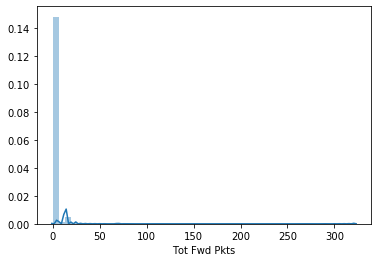

In [20]:
# plot a histogram of a sample of our dataset with a kde kernal density estimate overlaid 
sns.distplot(gdf['Tot Fwd Pkts'].head(1000))

It looks like our data has a long tail distribution. We can visualize it another way with a cummulative frequency histogram.

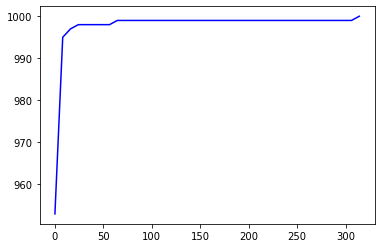

In [26]:
# evaluate the histogram
values, base = np.histogram(gdf['Tot Fwd Pkts'].head(1000).to_pandas(), bins=40)

#evaluate the cumulative
cumulative = np.cumsum(values)

# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue')
plt.show()

It looks like over 99.5% of our traffic has less than 25 total forward packets. Could we just flag all the traffic with greater than 25 forward packets as anaomolous? Is this a good idea? Why or why not?

Let's plot another data field, `Flow Duration`.

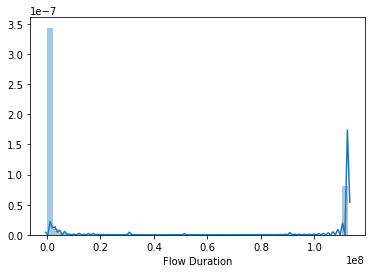

In [27]:
#plot a histogram of a sample of our dataset with a kde kernal density estimate overlaid 
sns.distplot(gdf['Flow Duration'].head(1000))

It looks like `Flow Duration` is bimodal, what would it mean to have a single threshold to determine outliers within this field?

# Graph Representation of the Network Data

Networks (including cybersecurity networks) are frequently interpreted and represented as graphs. A graph representation affords us many benefits during analysis, including using both the structure, edge features, and generated features for anomaly detection. We first demonstrate how to create a [cuGraph](https://github.com/rapidsai/cugraph) representation of graph data represented in cuDF, then we walk through some analysis.

In [28]:
G = cugraph.Graph()

In [29]:
%%time
gdf['src_ip_r'], gdf['dst_ip_r'], numbering = cugraph.renumber(gdf['src_ip'], gdf['dst_ip'])

CPU times: user 44 ms, sys: 20 ms, total: 64 ms
Wall time: 64.6 ms


In [30]:
gdf.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Idle Mean,Idle Std,Idle Max,Idle Min,Label,datetime,src_ip,dst_ip,src_ip_r,dst_ip_r
0,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:50:13 PM,112640178,2,1,...,56320092.0,159.806137,56320200.0,56319976.0,No Label,1520038213,134610945,134219268,189,6461
1,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:53:02 PM,112642593,2,1,...,56321296.0,120.915260,56321384.0,56321212.0,No Label,1520038382,134610945,134219268,189,6461
2,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:55:51 PM,112640127,2,1,...,56320068.0,251.022903,56320240.0,56319884.0,No Label,1520038551,134610945,134219268,189,6461
3,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 12:58:40 PM,112641715,2,1,...,56320852.0,67.175140,56320904.0,56320812.0,No Label,1520038720,134610945,134219268,189,6461
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0,8.0.6.4,0,0,02/03/2018 01:01:29 PM,112642245,2,1,...,56321120.0,3.535534,56321124.0,56321120.0,No Label,1519995689,134610945,134219268,189,6461


In [31]:
%%time
G.add_edge_list(gdf['src_ip_r'],gdf['dst_ip_r'],None)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 603 µs


### Calculating the Degree

We'll find the number of connections at each node. This is often useful to see what nodes have the most connections, as these are typically backbone assets of the network.

In [32]:
%%time
deg = G.degree()

CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 12.5 ms


In [33]:
# top 3 most connected vertices 
print(deg.sort_values('degree', ascending=False).head(3))

       vertex   degree
1110     1110  2093163
28314   28314   506784
11418   11418   286191


This isn't super useful though since it's the internal cuGraph renumbering representation of the vertex. Ideally, we want the actual IPv4 address. We can do that via a quick [`merge` operation](https://rapidsai.github.io/projects/cudf/en/latest/api.html?highlight=merge#cudf.dataframe.DataFrame.merge).

In [34]:
%%time
ip_lookup_gdf = cudf.concat([gdf[['Src IP','src_ip_r']].rename({'Src IP': 'ip','src_ip_r':'vertex'}),
                             gdf[['Dst IP','dst_ip_r']].rename({'Dst IP': 'ip','dst_ip_r':'vertex'})]) \
                .drop_duplicates()

CPU times: user 304 ms, sys: 232 ms, total: 536 ms
Wall time: 536 ms


In [35]:
%%time
ip_to_vertex_gdf = deg.drop_duplicates() \
                        .merge(ip_lookup_gdf, how='left', left_on='vertex', right_on='vertex')

CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 30.8 ms


In [37]:
# top 10 most connected vertices
ip_to_vertex_gdf.sort_values('degree', ascending=False).head(10)

,vertex,degree,ip
220,1110,2093163,172.31.0.2
25600,28314,506784,169.254.169.254
14816,11418,286191,18.219.211.138
27045,20991,119999,5.101.40.43
34391,21265,110934,5.101.40.105
2851,189,83222,8.6.0.1
30179,6461,83222,8.0.6.4
20341,23183,72525,213.202.230.222
24806,30144,63190,72.21.91.29
27256,22834,59877,213.202.230.143


Now we have a better idea of what IPs have the highest degree. It looks like `172.31.0.2` is the highest, followed by the `169.254.169.254` IP address and the `18.219.211.138` address. Unfortunately, only one of these (the last one) is responsible for launching any attacks in this dataset. How can we write a different analytic that will move that IP address to the top of our triage list?

## Say Hello to PageRank

PageRank (PR) is a [fairly well-known algorithm](https://en.wikipedia.org/wiki/PageRank), originally developed to rank web pages in Google search results. Traditionally, the PageRank algorithm outputs a probability distribution which represents the likelihood that a person randomly clicking on links will arrive at any particular page. We can use that same property to rank states of an attack graph.

Fortunately for us, cuGraph makes it easy to calculate the PR of each node in a graph.

In [38]:
%%time
# Call cugraph.pagerank to get the pagerank scores
gdf_pr = cugraph.pagerank(G)

CPU times: user 116 ms, sys: 208 ms, total: 324 ms
Wall time: 332 ms


And here are some of the PR values.

In [39]:
gdf_pr.head()

,vertex,pagerank
0,0,0.000005
1,1,0.000013
2,2,0.000110
3,3,0.000005
4,4,0.000005


In order to find the most important node, we first find the maximum PR value

In [40]:
pr_max = gdf_pr['pagerank'].max()
print(pr_max)

0.14738354086875916


And we then write a function that can search for that vertex and return it.

In [41]:
# Use this value in a query to find the vertex and convert back to IP
def print_pagerank_threshold(_df, t=0) :
    filtered = _df.query('pagerank >= @t')    
    for i in range(len(filtered)):
        print("The most important vertex is " + str(filtered['vertex'][i]) + 
            " with a pagerank score of " + str(filtered['pagerank'][i]))

In [42]:
print_pagerank_threshold(gdf_pr, pr_max)

The most important vertex is 1110 with a pagerank score of 0.14738354


We know either by looking or by writing some more code that the node with the maximum PR value corresponds to the IP address `172.31.0.2`. That's the IP address that had the highest degree, and it's not one of the IPs that responsible for the botnet attack. Well that wasn't super useful.

## Personalized PageRank to the Rescue

The issue for us is that PageRank sets the initial weights of all the nodes the same. In other words, it assumes a uniform starting probability for every node. What if we have _a priori_ information about the nodes? In this context, what if we know some of the victim IP addresses, and we're not sure we have identified all of them? We can use personalized PageRank (PPR) to assist.

We first construct a list of `training_victim_ips`. These are the IP addresses that we _know_ to be compromised. But since we have ground truth data, we also know _all_ of the affected IP addresses. We'll make another list for those (but we don't use them in training).

In [43]:
# the victim IPs we're going to consider for training
training_victim_ips = ['172.31.69.23','172.31.69.17', '172.31.69.14', '172.31.69.12', '172.31.69.10', 
              '172.31.69.26', '172.31.69.29', '172.31.69.30']

# all of the victim IPs we know via ground truth
all_victim_ips = ['172.31.69.23','172.31.69.17', '172.31.69.14', '172.31.69.12', '172.31.69.10', '172.31.69.8', 
              '172.31.69.6', '172.31.69.26', '172.31.69.29', '172.31.69.30']

# we know the times of the attack, so we put the [start, stop] times here for reference
attack_time_1 = [1519999860, 1520004840]
attack_time_2 = [1520015040, 1520020500]

We can now filter out the attack flows. There were two attacks at two different times on this date. We construct two DFs for each attack. We then assign a label of `1` if the flow represents an attack and `0` if it's benign. We do this for all IP addresses in our training set over the two affected time periods.

TL;DR - we're constructing a labeled training set. More accurately in this case, we're constructing a dataset to help us set initial probabilities (weights) for the PPR algorithm.

In [44]:
%%time
attack1_gdf = gdf[(gdf['Src IP'] == "18.219.211.138") & ((gdf['Dst IP'] == training_victim_ips[0]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[1]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[2]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[3]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[4]) |
                                                         (gdf['Dst IP'] == training_victim_ips[5]) |
                                                         (gdf['Dst IP'] == training_victim_ips[6]) |
                                                         (gdf['Dst IP'] == training_victim_ips[7])) &
                    (gdf['datetime'] > attack_time_1[0]) * (gdf['datetime'] < attack_time_1[1])]

attack2_gdf = gdf[(gdf['Src IP'] == "18.219.211.138") & ((gdf['Dst IP'] == training_victim_ips[0]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[1]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[2]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[3]) | 
                                                         (gdf['Dst IP'] == training_victim_ips[4]) |
                                                         (gdf['Dst IP'] == training_victim_ips[5]) |
                                                         (gdf['Dst IP'] == training_victim_ips[6]) |
                                                         (gdf['Dst IP'] == training_victim_ips[7])) &
                    (gdf['datetime'] > attack_time_2[0]) * (gdf['datetime'] < attack_time_2[1])]

attack_flow_ids_gdf = cudf.concat([attack1_gdf,attack2_gdf])['Flow ID'].unique().to_frame(name='Flow ID')
attack_flow_ids_gdf['Label'] = int(1)

gdf = gdf.merge(attack_flow_ids_gdf, left_on=['Flow ID'], right_on=['Flow ID'], how='left', suffixes=('_orig',''))
gdf['Label'] = gdf['Label'].fillna(0)

CPU times: user 4.72 s, sys: 2.37 s, total: 7.09 s
Wall time: 12.3 s


Just for fun, the cell below performs the same task using pandas. It's commented out, but feel free to uncomment and compare timings.

In [45]:
# %%time
# gdf_as_pdf = gdf.to_pandas()

# attack1 = gdf_as_pdf[(gdf_as_pdf['Src IP'] == "18.219.211.138") & (gdf_as_pdf['Dst IP'].isin(training_victim_ips)) & 
#                    (gdf_as_pdf['datetime'] > attack_time_1[0]) & (gdf_as_pdf['datetime'] < attack_time_1[1])]

# attack2 = gdf_as_pdf[(gdf_as_pdf['Src IP'] == "18.219.211.138") & (gdf_as_pdf['Dst IP'].isin(training_victim_ips)) & 
#                    (gdf_as_pdf['datetime'] > attack_time_2[0]) & (gdf_as_pdf['datetime'] < attack_time_2[1])]

# attack_flow_ids = set(attack1['Flow ID']) | set(attack2['Flow ID'])

# gdf_as_pdf["Label"] = [int(1) if fid in attack_flow_ids else int(0) for fid in gdf_as_pdf['Flow ID']]

# gdf = cudf.DataFrame.from_pandas(gdf_as_pdf)

Let's inspect the head of the DF to make sure we have what we need.

In [46]:
gdf[['Label', 'datetime','Src IP', 'Dst IP', 'src_ip_r', 'dst_ip_r']].head(10).to_pandas()

,Label,datetime,Src IP,Dst IP,src_ip_r,dst_ip_r
0,0,1520038031,46.48.152.102,172.31.64.115,10921,1587
1,0,1520038017,172.31.64.115,111.221.29.254,1587,31591
2,0,1520038152,172.31.64.115,111.221.29.254,1587,31591
3,0,1520038150,172.31.64.115,72.21.91.29,1587,30144
4,0,1520038025,172.31.64.115,152.195.32.110,1587,7068
5,0,1520038160,172.31.64.115,152.195.32.110,1587,7068
6,0,1520038160,172.31.64.115,152.195.32.110,1587,7068
7,0,1520038011,172.31.64.115,52.84.58.35,1587,31341
8,0,1520038182,172.31.64.115,52.84.58.35,1587,31341
9,0,1520038182,52.84.58.35,172.31.64.115,31341,1587


Let's think about what we have here. We have _known attacks_ on _known IPs_. We also know there are some unknown number of other IPs that could be impacted. We want a way to prioritize what other IPs to investigate. Personalized PageRank take a `personalization vector` as an initialization parameter. Technically, this vector contains the transport probabilities for each node in the vector. For us, this amounts to setting some initial weights that are not uniform.

But how to do this? One straightforward way is, for each node, to count the number of attack-labeled edges it has. This is a task made for a `groupby().count()`.

In [47]:
%%time 
# Get only rows that are labeld as 1 (attack)
attacked_gdf = gdf[gdf['Label'] == 1]

# For each node, count how many attack-labeled edges it makes
aggregated_gdf = attacked_gdf.groupby(['src_ip_r']).count()

# Get personalization vector
# (make sure that the type of vertex is int32 and that of values is float32)
personalization_vec = cudf.DataFrame()
personalization_vec['vertex'] = aggregated_gdf.index.values
personalization_vec['values'] = aggregated_gdf['Timestamp'].astype('float32')

CPU times: user 1.89 s, sys: 804 ms, total: 2.7 s
Wall time: 3.43 s


We now have everything we need to run PPR. In cuGraph, PPR is the same function as regular PR. The only change is that we add a `personalization` parameter and feed it in the personalization vector we computed above.

In [48]:
%%time
# Run PPR
ppr = cugraph.pagerank(G, alpha=0.85, personalization=personalization_vec, max_iter=100, tol=1.0e-5, nstart=None)

CPU times: user 120 ms, sys: 44 ms, total: 164 ms
Wall time: 164 ms


Now what if we query the PPR results for the node with the maximum PPR value?

In [49]:
ppr_max = ppr['pagerank'].max()

print_pagerank_threshold(ppr, ppr_max)

The most important vertex is 11418 with a pagerank score of 0.38848737


Looking back in our original dataset, we see that this vertex corresponds to the IP address `18.219.211.138`. This is the same IP address that is responsible for initiating the botnet attacks.

In [50]:
gdf.query('src_ip_r == 11418').head(10).to_pandas()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Idle Std,Idle Max,Idle Min,Label_orig,datetime,src_ip,dst_ip,src_ip_r,dst_ip_r,Label
5350753,172.31.69.10-18.219.211.138-55063-8080-6,18.219.211.138,8080,172.31.69.10,55063,6,02/03/2018 03:23:29 PM,579,0,3,...,0.0,0.0,0.0,No Label,1520004209,316396426,2887730442,11418,6616,1
5363008,172.31.69.10-18.219.211.138-51985-8080-6,18.219.211.138,8080,172.31.69.10,51985,6,02/03/2018 07:53:43 PM,11355,4,3,...,0.0,0.0,0.0,No Label,1520020423,316396426,2887730442,11418,6616,1
5363010,172.31.69.10-18.219.211.138-51986-8080-6,18.219.211.138,8080,172.31.69.10,51986,6,02/03/2018 07:53:44 PM,17675,4,3,...,0.0,0.0,0.0,No Label,1520020424,316396426,2887730442,11418,6616,1
5364384,172.31.69.10-18.219.211.138-51543-8080-6,18.219.211.138,8080,172.31.69.10,51543,6,02/03/2018 07:50:18 PM,21134,4,3,...,0.0,0.0,0.0,No Label,1520020218,316396426,2887730442,11418,6616,1
5364386,172.31.69.10-18.219.211.138-51544-8080-6,18.219.211.138,8080,172.31.69.10,51544,6,02/03/2018 07:50:19 PM,39349,4,3,...,0.0,0.0,0.0,No Label,1520020219,316396426,2887730442,11418,6616,1
5364388,172.31.69.10-18.219.211.138-51546-8080-6,18.219.211.138,8080,172.31.69.10,51546,6,02/03/2018 07:50:19 PM,67747,4,3,...,0.0,0.0,0.0,No Label,1520020219,316396426,2887730442,11418,6616,1
5364390,172.31.69.10-18.219.211.138-51547-8080-6,18.219.211.138,8080,172.31.69.10,51547,6,02/03/2018 07:50:19 PM,14506,4,3,...,0.0,0.0,0.0,No Label,1520020219,316396426,2887730442,11418,6616,1
5364392,172.31.69.10-18.219.211.138-51548-8080-6,18.219.211.138,8080,172.31.69.10,51548,6,02/03/2018 07:50:19 PM,21378,11,2,...,0.0,0.0,0.0,No Label,1520020219,316396426,2887730442,11418,6616,1
5364394,172.31.69.10-18.219.211.138-51549-8080-6,18.219.211.138,8080,172.31.69.10,51549,6,02/03/2018 07:50:19 PM,10233,4,3,...,0.0,0.0,0.0,No Label,1520020219,316396426,2887730442,11418,6616,1
5364396,172.31.69.10-18.219.211.138-51550-8080-6,18.219.211.138,8080,172.31.69.10,51550,6,02/03/2018 07:50:20 PM,13775,4,3,...,0.0,0.0,0.0,No Label,1520020220,316396426,2887730442,11418,6616,1


Let's merge our PPR values back with this larger cuDF.

In [51]:
%%time
gdf = ppr.merge(gdf, how='left', left_on='vertex', right_on='src_ip_r')

CPU times: user 4.06 s, sys: 1.73 s, total: 5.78 s
Wall time: 5.91 s


Now the moment of truth. If we sort our entire cuDF by the PPR value, we should find those with a maximum PPR at the top. The hypothesis is that these IPs are involved in the attacks.

In [52]:
%%time 
gdf[['Src IP','Src Port','Dst IP','pagerank']] \
        .drop_duplicates() \
        .sort_values(by='pagerank', ascending=False) \
        .head(15) \
        .to_pandas()

CPU times: user 308 ms, sys: 320 ms, total: 628 ms
Wall time: 633 ms


,Src IP,Src Port,Dst IP,pagerank
245784,18.219.211.138,8080,172.31.69.10,0.388487
443818,18.219.211.138,8080,172.31.69.17,0.388487
544861,18.219.211.138,8080,172.31.69.29,0.388487
563046,18.219.211.138,8080,172.31.69.30,0.388487
649214,18.219.211.138,8080,172.31.69.6,0.388487
977682,18.219.211.138,8080,172.31.69.8,0.388487
6540162,172.31.69.30,0,131.202.242.193,0.130269
3311771,172.31.69.30,0,18.219.211.138,0.130269
7472896,172.31.69.30,0,209.85.203.91,0.130269
3226338,172.31.69.30,0,224.0.0.22,0.130269


In [53]:
training_victim_ips

['172.31.69.23',
 '172.31.69.17',
 '172.31.69.14',
 '172.31.69.12',
 '172.31.69.10',
 '172.31.69.26',
 '172.31.69.29',
 '172.31.69.30']

A visual inspection of this table shows us that there are IPs we suspect. Looking in the `Dst IP` column, we find `172.31.69.10`, `172.31.69.17`, `172.31.69.29`, and `172.31.69.30`. But we also see `172.31.69.6` and `172.31.69.8`. These were not in our original training dataset (meaning we assumed we didn't know about them), but they _are_ victims of the attack as shown in the ground truth dataset. Neat.

We've talked about PageRank and Personalized PageRank, but there are other graph analyitcs availabe in cuGraph. One of them is [Louvain modularity](https://rapidsai.github.io/projects/cugraph/en/0.8.0/api.html?highlight=louvain#cugraph.nvLouvain) (community detection). Calculating the partitions is fairly straightforward:

```louvain_parts, modularity_score = cugraph.louvain(G)```

Use Louvain modularity to partition the network graph, and investigate the results. Are all the the victim IPs in the same community? Would you expect them to be?

In [54]:
%%time
louvain_parts, modularity_score = cugraph.louvain(G)

CPU times: user 268 ms, sys: 152 ms, total: 420 ms
Wall time: 417 ms


<hr />

## Acknowledgmnets

We would like to thank the [Canadian Institute for Cybersecurity](https://www.unb.ca/cic/) for the data used in this tutorial. A complete description of the dataset used is [available online](https://registry.opendata.aws/cse-cic-ids2018/). In addition, the paper associated with this dataset is:

> Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018

We would also like to acknowledge the contributions of Eli Fajardo (NVIDIA), Brad Rees, PhD (NVIDIA), and the [RAPIDS](https://rapids.ai) engineering team.